# Playing Time Influenced by Gender as a Predictor for Game Newsletter Subscription
By Group 23 (Aayush, Kathleen, QingYou, Gordon) 

## Introduction
**Background:** 

Online games increasingly use newsletter subscriptions to enhance user engagement and market new features. Understanding what motivates players to subscribe can help improve marketing and tailor experiences to different player types.

**Question 1 (General):** 

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Interpretation:** 

What is the relationship between total played hours and subscription class of a player? How does a player’s gender strengthen or weaken the predictive ability of average session time for subscription class?

**Dataset Overview**

To answer this question, we will use the players.csv file. The `players` dataset includes 196 observations and 7 variables describing player demographic information. The dataset size is sufficient for meaningful predictive modeling. The variables are given below.

| Variable | Type | Description |
|--------|----|-----------|
| `experience` | character | Player's skill level |
| `subscribe` | logical | Indicates whether player subscribed to a game-related newsletter |
| `hashedEmail` |character | Unique identifier for each player (hashed) |
| `played_hours` | numeric | The total hours the player has played |
| `name` | character | Player's name |
| `gender` | character | Gender |
| `Age` | numeric | Player's age |

Some brief summary statistics of the quantitative variables in the `players` dataset:
| Stat | `played_hours` | `Age` |
| ---- | ---- | ---- |
| count | 196 | 194 |
| mean | 5.845918 | 20.52062 |
| median | 0.1 | 6.174667 |
| standard deviation | 28.35734 | 19 |
| min | 0 | 8 | 
| max | 223.1 | 50 | 

Some issues in the dataset are listed here:
* There might be some subjective inconsistencies with `experience` if it was self-reported.
* `Age` has 2 missing values.
* `experience` and `gender` should be factor variables.
* Distribution imbalances in variables like `subscribed`, `gender`, and `Age`.

Response variable:
* `subscribe`: Inidcates whether a player is subscribed to a game-related newsletter or not and is what we aim to predict.

Explanatory variables:

* `played hours`: In-game engagement time likely impacts the likelihood of players seeking out more game-information on newsletters.
* `gender`: For simplicity, we use a binary flag where one flag is male and the other is gender-diverse, which is an umbrella term that we will apply here to include women, non-binary people, two-spirit people, agender people, and those who responded 'other' in the survey. We will exclude those who answer 'prefer not to say'. We are interested on the possible effects this variable might have on the predictive capabilities of `played hours` on `subscribe` (If there is any).

## Methods and Results

To explore the impacts of gender on the predictive ability of `played hours`, we will start by training a classifier including data from all players. `played_hours` will be used as the predictive variable for the binary classification `subscribe` in a standard knn classification scheme. Then, we will split the data into two groups: one comprised of only male players, and one comprised of only gender diverse players. We will train one new classifier on each. This will leave us with three classifiers which we can then directly compare the skill of using standard classification metrics. 

**Loading and Wrangling of Data**

Getting necessary libraries and reading in players.csv dataset: 

In [12]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [13]:
players <- read_csv('https://raw.githubusercontent.com/kathleenramsey/dsci100_group23/main/Project%20Planning%20Players.csv')
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Below we are creating three datasets (for our three models) from the original players dataset. 
1. The first dataset (players_full) has those who haven't specified a gender filtered out. `gender` variable modified, with `male` representing males and `gender_diverse` representing female, non-binary, two-spirited, etc.
2. The second dataset (players_male) contains only males.
3. The third contains (players_gd) contains all listed genders except for males.
4. Each dataset only contains `played_hours`, `gender`, (explanatory) and `subscribe` (response) columns. Additionally, `subscribe` is converted into a factor variable for all three as well.

In [26]:
players_full <- players |>
    select(subscribe, played_hours, gender) |>
    filter(gender != 'Prefer not to say') |>
    mutate(gender = if_else(gender == "Male", "male", "gender_diverse")) |>
    mutate(subscribe = as.factor(subscribe))

players_male <- players |>
    select(subscribe, played_hours, gender) |>
    filter(gender == 'Male') |>
    mutate(subscribe = as.factor(subscribe))

players_gd <- players |>
    select(subscribe, played_hours, gender) |>
    filter(gender != 'Male', gender != 'Prefer not to say') |>
    mutate(subscribe = as.factor(subscribe))

**Relevant Statistics**

Below we are getting some statistics on the variables from our plaayers_full dataset we will use for our analysis. We can see roughly 3/4 of the players are subscribed to a game-related newspaper. More than half of our players are male and that there is a clear inbalance in `played_hours` as seen with the median.

In [45]:
`subscription_%` <- players_full |>
    group_by(subscribe) |>
    summarize(count = n()) |>
    mutate(percentage = (count / sum(count)) * 100)
`subscription_%`

`gender_%` <- players_full |>
    group_by(gender) |>
    summarize(count = n()) |>
    mutate(percentage = (count / sum(count)) * 100)
`gender_%`

played_hours_summary <- players_full |>
    select(played_hours) |>
    summarize(mean = mean(played_hours, na.rm = TRUE),
              sd = sd(played_hours, na.rm = TRUE),
              median = median(played_hours, na.rm = TRUE),
              min = min(played_hours, na.rm = TRUE),
              max = max(played_hours, na.rm = TRUE))
played_hours_summary

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,45,24.32432
TRUE,140,75.67568


gender,count,percentage
<chr>,<int>,<dbl>
gender_diverse,61,32.97297
male,124,67.02703


mean,sd,median,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.171351,29.15973,0.1,0,223.1


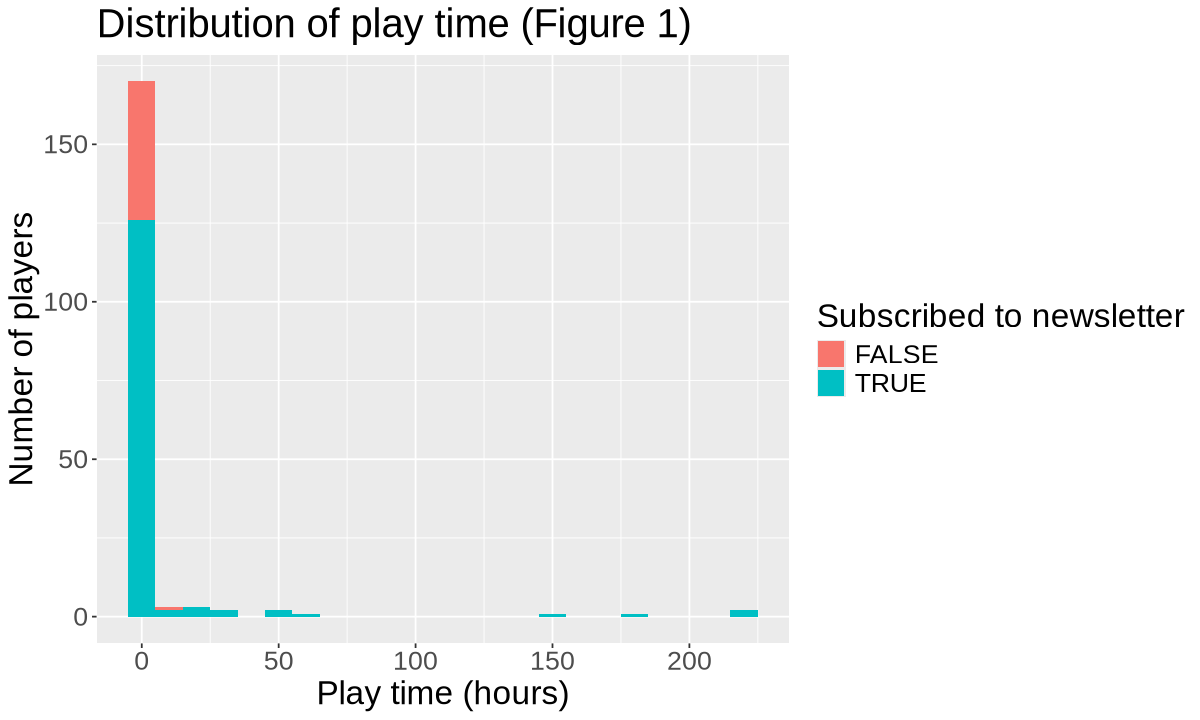

In [27]:
options(repr.plot.height = 6, repr.plot.width = 10)

prop_sub <- players_full |>
  summarise(prop_subscribed = mean(subscribe == TRUE)) |>
    pull()

player_hist <- players_full |>
    ggplot(aes(x=played_hours, fill=subscribe)) +
    geom_histogram(binwidth=10) +
    labs(x='Play time (hours)',
         y='Number of players',
         fill='Subscribed to newsletter',
         title = 'Distribution of play time (Figure 1)') +
    theme(text = element_text(size = 20))
player_hist

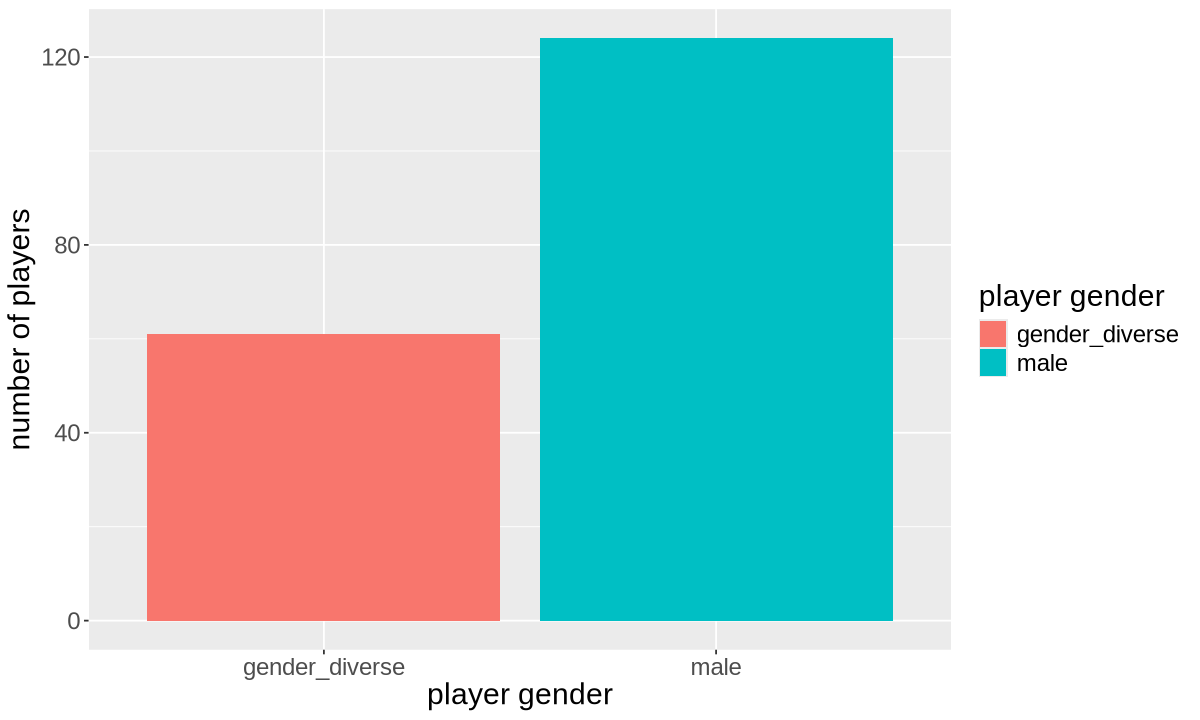

In [16]:
options(repr.plot.height = 6, repr.plot.width = 10)

player_genders <- players_full |>
    ggplot(aes(x=gender, fill=gender)) +
    geom_bar(stat='count') +
    labs(x='player gender', y='number of players', fill='player gender') +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set2")


player_genders

2. Make training/testing splits. Train one classifier on data with all genders, choose optimum k

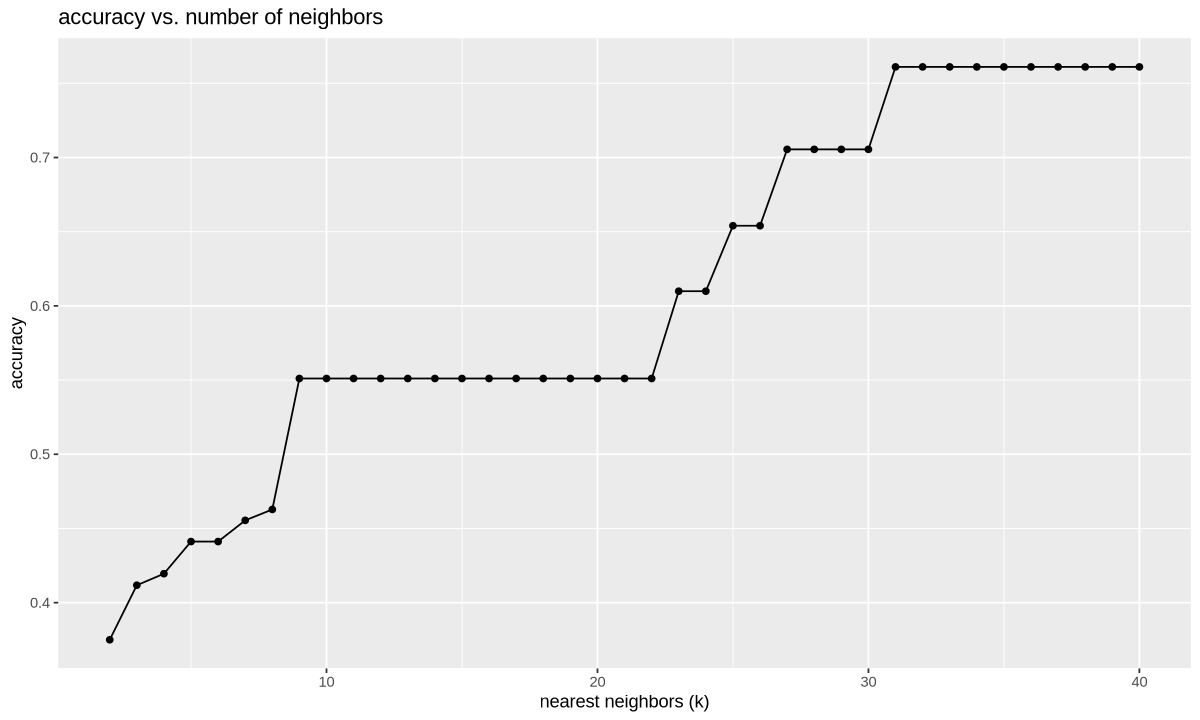

In [17]:
# refer to worksheets/tutorials on classification ???
# use a CV (probably 4-fold) to do training/validation only on the players_full set, not the split sets
# i don't think that the split sets have enough data points to do a good train/test split and still get reliable results from CV
# so if we can find a k value with just the full set we can use that k value for the split sets too.

set.seed(23) 

full_split <- initial_split(players_full, prop = 0.75, strata = subscribe)
full_train <- training(full_split)
full_test <- testing(full_split)

k_vals <- tibble(neighbors = c(2:40))
knn_vfold <- vfold_cv(full_train, v = 4, strata = subscribe)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_recipe <- recipe(subscribe ~ played_hours, data = full_train)

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune)

knn_results <- tune_grid(
    knn_workflow,
    resamples = knn_vfold,
    grid = k_vals
)

knn_metrics <- knn_results |>
    collect_metrics() |>
    filter(.metric == "accuracy")

cross_val_plot <- knn_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "accuracy vs. number of neighbors",
         x = "nearest neighbors (k)",
         y = "accuracy")

print(cross_val_plot)

3. Using the optimal k found earlier, train classifiers on split data

In [18]:
set.seed(23)

best_k <- 32

knn_model2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")


knn_workflow2 <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_model2)

knn_fit <- fit(knn_workflow, data = full_train)

Warning message:
“tune samples were requested but there were 138 rows in the data. 133 will be used.”


4. Evaluate classifiers, gather skill metrics, compare and discuss

In [19]:
# this is kind of discussion territory but we can see how the flow of the analysis goes
knn_preds <- predict(knn_fit, new_data = full_test)

knn_results <- bind_cols(knn_preds, full_test)

knn_metrics <- knn_results |>
  metrics(truth = subscribe, estimate = .pred_class)|>
  filter(.metric=="accuracy")

print(knn_metrics)


# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.745


In [20]:
# Train KNN model for male players and make predictions for male players in the test set
knn_fit_male <- knn_workflow |>
  fit(data = players_male)

knn_preds_male <- predict(knn_fit_male, new_data = full_test %>% filter(gender == "male"))

knn_results_male <- bind_cols(knn_preds_male, full_test %>% filter(gender == "male"))

# Calculate evaluation metrics for male players
knn_metrics_male <- knn_results_male |>
  metrics(truth = subscribe, estimate = .pred_class)|>
  filter(.metric=="accuracy")

print(knn_metrics_male)

Warning message:
“tune samples were requested but there were 124 rows in the data. 119 will be used.”


# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.677


In [21]:
# Train the KNN model for gender-diverse players and make predictions for gender-diverse players in the test set
knn_fit_gd <- knn_workflow |>
  fit(data = players_gd)

knn_preds_gd <- predict(knn_fit_gd, new_data = full_test %>% filter(gender == "gender_diverse"))

knn_results_gd <- bind_cols(knn_preds_gd, full_test %>% filter(gender == "gender_diverse"))

# Calculate evaluation metrics for gender-diverse players
knn_metrics_gd <- knn_results_gd |>
  metrics(truth = subscribe, estimate = .pred_class)|>
  filter(.metric=="accuracy")

print(knn_metrics_gd)

Warning message:
“tune samples were requested but there were 61 rows in the data. 56 will be used.”


# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.875


### Summary of Results (Accuracy):

1. **For the full dataset (all players):**
   - Accuracy: **0.745** (74.5%)

2. **For male players:**
   - Accuracy: **0.677** (67.7%)

3. **For gender-diverse players:**
   - Accuracy: **0.875** (87.5%)

### Interpretation:
- The model works the same for the full dataset and male players (67.7% accuracy).
- The model works better for gender-diverse players, with an accuracy of 87.5%. This means the model can predict subscription behavior more accurately for gender-diverse players than for male players.

5.creates a visualization of the analysis


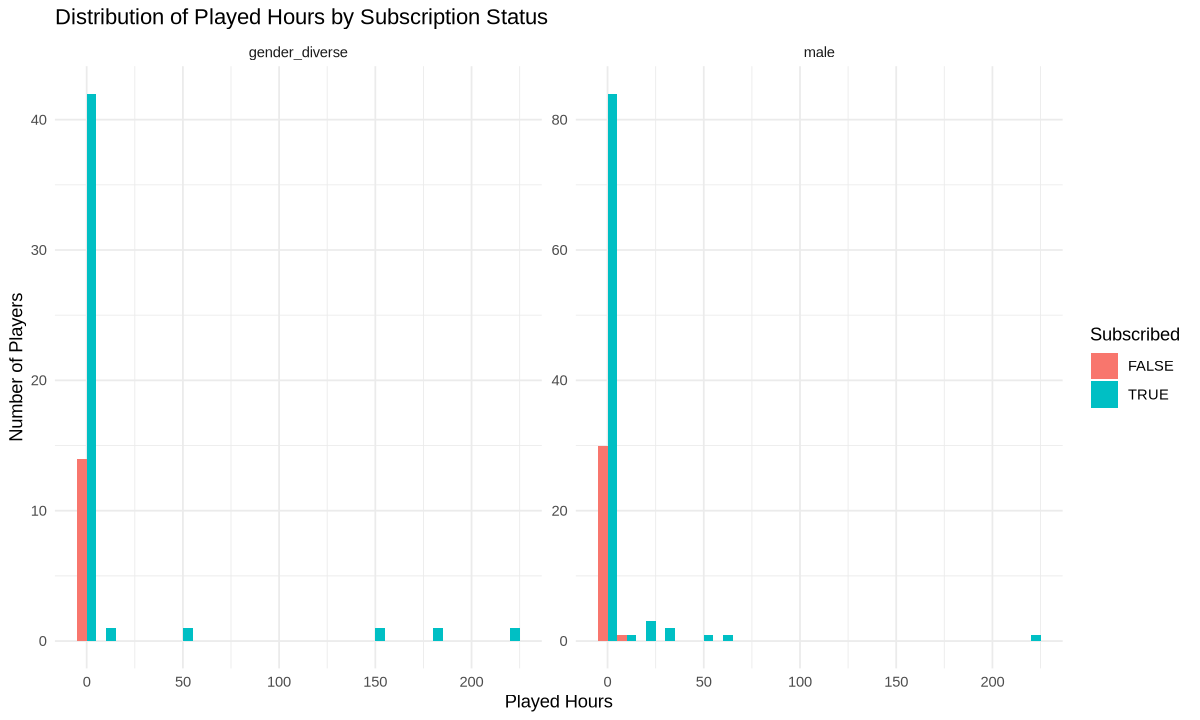

In [22]:
options(repr.plot.height = 6, repr.plot.width = 10)
# Combine all player data for the plot
players_full <- players |>
  select(subscribe, played_hours, gender) |>
  filter(gender != 'Prefer not to say') |>
  mutate(gender = if_else(gender == "Male", "male", "gender_diverse")) |>
  mutate(subscribe = as.factor(subscribe))

# Create a histogram for all players
ggplot(players_full, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 10, position = "dodge") +
  labs(
    title = "Distribution of Played Hours by Subscription Status",
    x = "Played Hours",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal() +
  facet_wrap(~gender, scales = "free") 


### Explanation:
- **`geom_histogram()`**: Creates the histogram, where `binwidth` specifies the width of each bar in the histogram.
- **`position = "dodge"`**: This separates the bars for players who subscribed and those who did not.
- **`facet_wrap(~gender)`**: This creates separate histograms for male and gender-diverse players, allowing for easy comparison between the groups.
- **`labs()`**: Adds titles and axis labels to the plot.

This visualization will help us see how the distribution of played hours differs between subscribed and non-subscribed players and also how this pattern might vary between male and gender-diverse players.

## Discussion

### Summary of Findings:

The KNN models trained on different groups of players showed that total played hours is an important factor in predicting whether a player subscribes to a game-related newsletter. Players who spend more time playing the game are more likely to subscribe to the newsletter. This was true for both male and gender-diverse players, though there was a difference in model performance.
- **For all players (combined)**: The model had an accuracy of 74.5%. This means that played hours can give a good prediction of subscription likelihood.
- **For male players**: The accuracy was 67.7%, showing that while played hours are still important, the model is less reliable for predicting subscriptions in male players.
- **For gender-diverse players**: The accuracy was 87.5%, suggesting that played hours are a stronger predictor for this group. Gender-diverse players may have a clearer relationship between their in-game time and subscription behavior.

### Is this what you expected to find?

- **Expected Outcomes**: We thought that total played hours would be an important factor for predicting newsletter subscriptions because players who play more may want to get more information, like newsletters. This fits with our expectations, as time spent in the game likely shows an interest in staying informed about game updates, events, and other content.
  
- **Unexpected Outcomes**: The difference in model performance between male and gender-diverse players was surprising. We thought played hours would be useful for both groups, but the model did better for gender-diverse players. This means that their behavior in the game might match their subscription choices more clearly. It also shows that gender might affect not just the chance of subscribing but also how players react to game marketing. This could depend on their interests, gaming habits, or how much they engage with the game community.

The lower accuracy for male players suggests that there are other factors—possibly not in this dataset—that influence their decision to subscribe to newsletters. It may also mean that male players’ subscription behavior is less linked to in-game hours, or that including other features (like experience or age) would improve the model for this group.

In conclusion, the analysis showed that played hours is an important predictor for newsletter subscriptions, but it works better for gender-diverse players. This means that while played hours are helpful, exploring more features and improving the model (especially for male players) could make predictions more accurate for all players. Gender differences in how played hours predict subscription behavior could also be interesting to study further, as they may help us understand player behavior and improve marketing strategies.

### Discussion: What impact could such findings have?


Our findings and results emphasize how crucial it is to take gender diversity into consideration when developing predictive models for user behavior analysis:

**Targeted Marketing Strategies:** Since we have shown that subscription behaviour is more predictable for gender-diverse players, companies can use this insight to create more engaging marketing campaigns for gender-diverse users without over-targeting or overlooking certain groups.

**Gaming Product Design:** Game developers can explore if their game or newsletters appeal differently to gender-diverse users and then use those discoveries to create more inclusive, engaging game features.

**Encourages Inclusive Data Science Methods:** Our research highlights the importance of including a diverse range of demographics groups when collecting data in order to gain a more complete picture of user behaviour.

**Discovering Hidden Model Biases:** The discrepancy between our overall accuracy (74.5%), male-only accuracy (67.7%), and gender-diverse accuracy (87.5%) demonstrates that certain subgroups may underperform or excel with specific models. This shows that data analysis should always involve routine subgroup analysis when evaluating accuracy of a given model.

### Discussion: What future questions could this lead to?

Our findings and results open the door to a variety of thought-provoking questions that require further analysis to answer such as:


1. Can we improve male player accuracy? Why does the male-only model perform worse than the full dataset model? Does the relationship between playtime and subscription for male players create an increase in variability that needs to be considered?

2. Why is subscription behavior more predictable for gender-diverse players? What behavioural patterns are more consistent for gender-diverse users?

3. What reasons do different genders value the game and newsletter for? Is it the actual content of the game? Are certain genders more likely to develop an emotional connection? For instance, some players may feel a stronger emotional attachment because of the inclusivity and representation in the game and the community. Are certain genders more likely to rely on the newsletter or external sources for updates on the game?

4. How might other factors and their interactions with gender affect subscription predictability? For example, what would change if we also used experience or age as predictors?

5. How would our results change in larger datasets or different types of games?
